<a href="https://colab.research.google.com/github/rghimre3/INFO5505_Machine_Learning_for_Data_Scientist/blob/main/brain_tumor_detection_using_CNN_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**date**: 2nd March, 2023

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. Brain Tumor Definition </a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The major goal of this project was to create a CNN model that would use an MRI scan to determine if a subject has a tumor or not. I utilised [VGG-16] To train the model for this binary problem, consider the model's weights and architecture. I utilized "accuracy" as a statistic to support the performance of the model, which is defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~33% |
| Test Set* | ~80% |
<br>
| Set | Original Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *N/B:*
* *`validation set` - is the set that was utilized to set the hyperparameters during model training. *
* *`test set` - is the small set that I completely avoid touching throughout the entire training procedure. It has been utilized to assess the performance of the final model.*

## <a id='dataset'>1.1. Data Set Description</a>

The image information utilized to solve this issue is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It consists of two groups of MRI images:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Sadly, the data set description has no information about the origin of the MRI scans or anything else.

## <a id='tumor'>1.2. Brain Tumor Definition</a>

> As abnormal cells develop within the brain, a tumor is created. Tumors can be classified as either cancerous (malignant) or benign. Cancerous tumors can be separated into primary tumors, which begin inside the brain, and secondary tumors, or brain metastasis tumors, which have spread from somewhere else. Depending on where section of the brain is affected, all types of brain tumors can cause a variety of symptoms. Headaches, seizures, eye issues, nausea, and mental disturbances are a few examples of these symptoms. Typically, a headache gets better in the morning and disappears with vomiting. Additional signs may include trouble speaking, walking, or feeling things. Unconsciousness could happen as the illness worsens.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [ ]:
#install required libraries
from IPython.display import clear_output
!pip install imutils
clear_output()
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#import required libraries
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Currently, all photographs are contained in a single folder with subfolders labeled `yes` and `no`. To make my task easier, I'll divide the data into `train`, `val`, and `test` folders. Below is the new folder heirarchy:

In [ ]:
IMG_PATH = 'Dataset/'
# splitting the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>3. Data Import and Preprocessing</a>

We load images from a given directory and stores them as np.arrays. The images are also resized according to a given img_size. Labels corresponding to each image is also created and stored in a dictionary.
Finally, the total number of images loaded is printed.

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

We load and prepare the image data for the model. The variables X_train, y_train, labels, X_test, y_test, X_val, and y_val are declared and assigned with data from the TRAIN, TEST, and VAL directories respectively. The image size is set to (224,224) for all images. The load_data() function is used to read in the image data from the directories.

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]


14 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s]


10 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.18it/s]

6 images loaded from VAL/ directory.


Let's take a look at the distribution of classes among sets:

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


This function takes in a set of images (X), their associated labels (y), and a labels dictionary
that maps numerical labels to text labels. It then creates a gridplot of the desired number of images
(n) from the specified set. The gridplot features each image with its corresponding text label,
with the entire gridplot labelled with the text label of the tumor type.


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

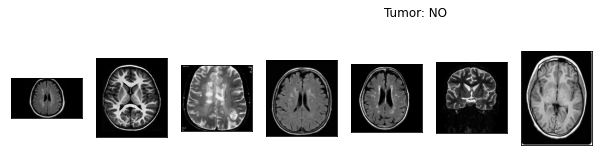

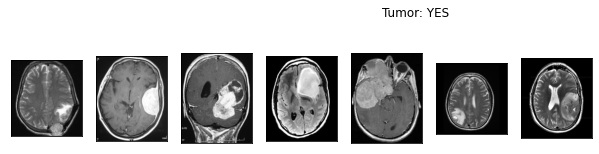

In [ ]:
plot_samples(X_train, y_train, labels, 30)

As you can see, each image has a varied "width," "height," and "black corner" size. Certain broad photographs may look strange after being resized since the image size for the VGG-16 imput layer is "(224,224)". ratio distribution histogram ('ratio = width/height')

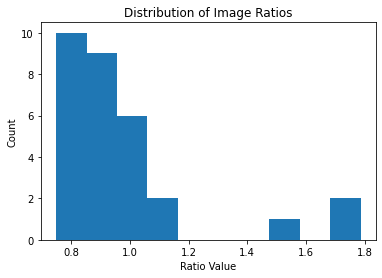

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

Cropping the brain from the photos would be the first stage of "normalization". I utilized a method that [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog precisely detailed, and I strongly advise looking into it further.

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [ ]:
img = cv2.imread('Input/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# do a sequence of erosions +
# dilations after thresholding the image to get rid of any minor noisy patches.
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# With a thresholded image, look for contours and then select the biggest one.
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# finding the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# adding contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# adding extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# cropping
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

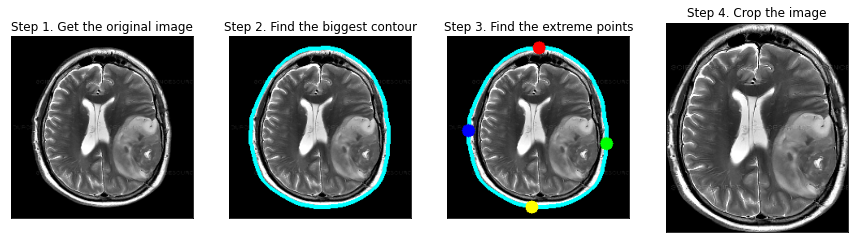

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# applying this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

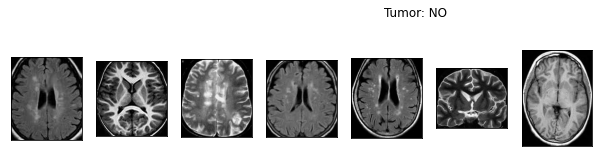

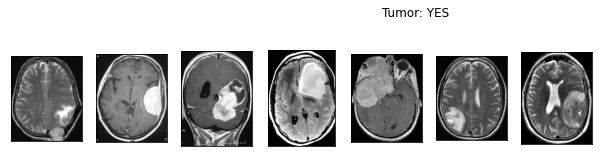

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
#function for saving images
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder:
#  TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


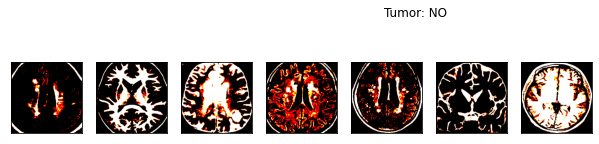

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


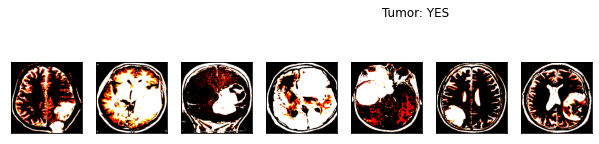

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

Using VGG-16 architecture and weights as a foundation model, I was utilizing [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e).

## <a id='aug'>4.1. Data Augmentation</a>

In order to "raise" the size of the training set, I utilized a method called "Data Augmentation" (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

### <a id='demo'>4.1.1. Demo</a>

There is an illustration of how augmentation appears in one photograph.

In [ ]:
# setting the paramters we wil to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

setting up an ImageDataGenerator object to be used for training and validation of a machine learning model. The ImageDataGenerator object can be used to apply a variety of data augmentation techniques to the training data, such as rotation, width and height shifting, shearing, zooming, and horizontal flipping. This can help to increase the diversity of the training data, which can in turn help to improve the accuracy of the model. The validation data is not augmented, as it is used to evaluate the model's performance on unseen data.

In [ ]:
#for trial from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=27,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=False)

validation_datagen = ImageDataGenerator()

creating a directory called 'preview' and then uses a data generator to perform image augmentation on the first image from the X_train_crop dataset. The data generator then saves the augmented images to the 'preview' directory, with the name 'aug_img' followed by a number for each image. The loop breaks after 20 augmented images have been created.

In [ ]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

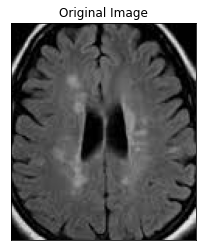

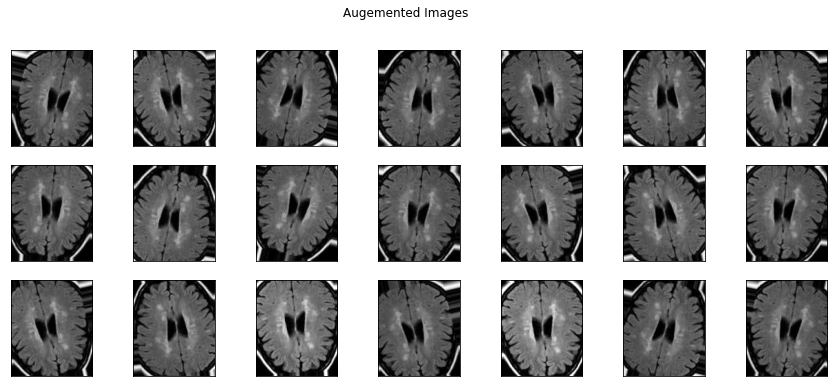

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

### <a id='apply'>4.1.2. Apply</a>

Now we define the parameters for a data generator object, which is used for loading images for training and validation. The train_datagen object uses parameters such as rotation_range, width_shift_range, height_shift_range, shear_range, brightness_range, horizontal_flip, and vertical_flip to create random transformations on the images while they are being loaded. The test_datagen object is used to only preprocess the images.

The train_generator and validation_generator objects are then used to load the images from the train and validation directories and apply the transformations defined in the train_datagen and test_datagen objects.

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 14 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [ ]:
# loading base model
vgg16_weight_path = 'Model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
)
vgg16_weight_path

553467096/553467096 [==============================] - 544s 1us/step


'Models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Compile model

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 138,358,545
Trainable params: 1,001
Non-trainable params: 138,357,544
_________________________________________________________________


### Fit model

In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=1
)

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,

)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.7003 - accuracy: 0.2143
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 0.6916 - accuracy: 0.5714
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 0.6912 - accuracy: 0.4286
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 0.6911 - accuracy: 0.7143
Epoch 5/10
1/1 [==============================] - 7s 7s/step - loss: 0.6964 - accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.6930 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 8s 8s/step - loss: 0.6938 - accuracy: 0.6429
Epoch 8/10
1/1 [==============================] - 7s 7s/step - loss: 0.7004 - accuracy: 0.3571
Epoch 9/10
1/1 [==============================] - 7s 7s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 6s 6s/step - loss: 0.6922 - accuracy: 0.5714


## <a id='perf'>4.3. Model Performance</a>

We start by creatings a figure with two plots, one for model accuracy and one for model loss. The accuracy and loss are taken from the history object which is the result of the training process. The range of the x-axis is set to the number of epochs specified in the training process. The legend is set to the best position and the titles of the plots are set as 'Model Accuracy' and 'Model Loss'.

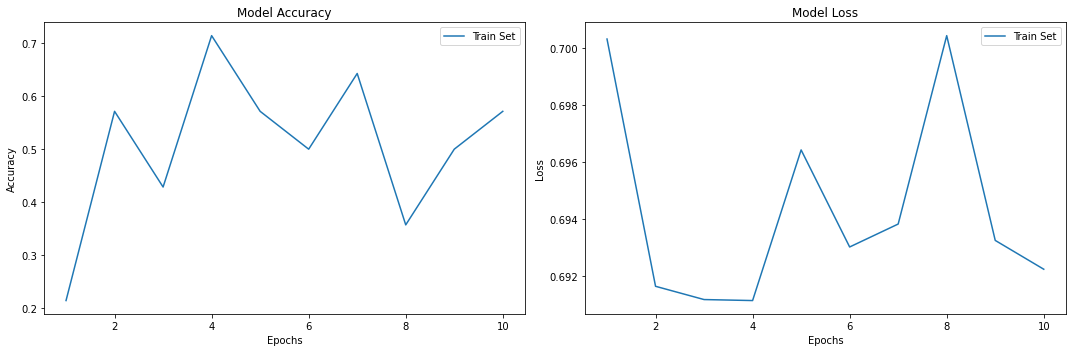

In [ ]:
# plot model performance
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
# plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
# plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Validating the model on the validation set. It is first predicting the labels for the validation set using the model, then it is converting the predictions into binary labels. Next, it is calculating the accuracy of the prediction by comparing it to the true labels. Finally, it is producing a confusion matrix to visualize the performance of the model.

1/1 [==============================] - 3s 3s/step
Val Accuracy = 0.33


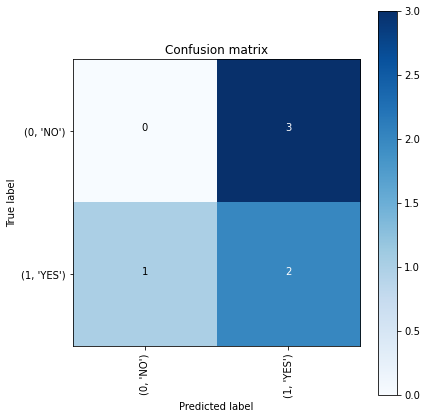

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Validating a model on a test set. It is using the model.predict() method to generate predictions from the X_test_prep dataset. The predictions are then converted to a binary output (1 if prediction>0.5, else 0) and tested against the actual labels in y_test. The accuracy of the model is then calculated and a confusion matrix is plotted to visualize the accuracy.

1/1 [==============================] - 4s 4s/step
Test Accuracy = 0.60


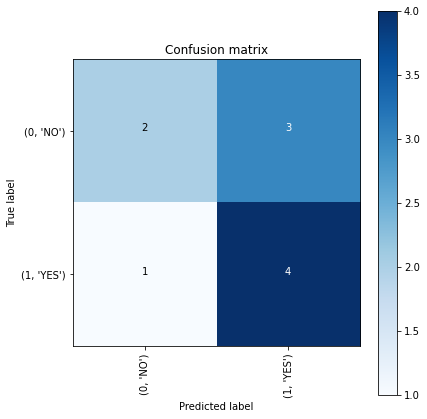

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Let's now examine the photos from the `test set` that were incorrectly categorized.:

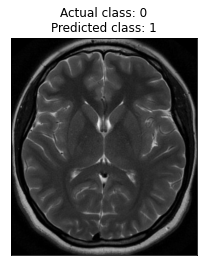

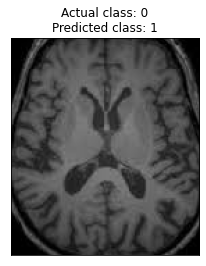

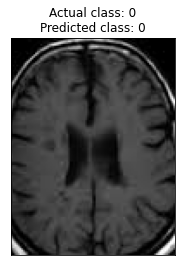

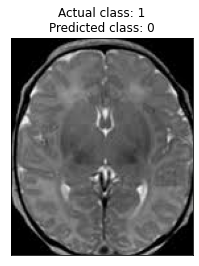

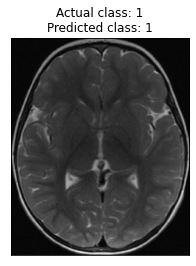

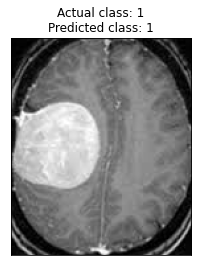

In [ ]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in range(6):
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

The first scan appears to be a little deceiving; what is that bright spot in the middle? 🤔 I see exactly why the model classed it as a `tumor`.

# <a id='concl'>5. Conclusions</a>

This research combined a computer vision problem with a CNN model classification challenge to determine whether the person had a brain tumor or not (to automate the process of brain cropping from MRI scans). The ultimate accuracy exceeds the 50% baseline by a wide margin (random guess). It might, however, be raised by using more train images or by fine-tuning the model hyperparameters.

In [ ]:
# clean up the space
# !rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('ModelOutput/brain_tumor_detection-model.h5')